# CS 20 : TensorFlow for Deep Learning Research
## Lecture 11 : Recurrent Neural Networks
Simple example for Many to One Classification (word sentiment classification) by Recurrent Neural Networks. 

### Many to One Classification by RNN
- Creating the **data pipeline** with `tf.data`
- Preprocessing word sequences (variable input sequence length) using `padding technique` by `tf.keras.preprocessing.sequence.pad_sequences`
- Using `tf.nn.embedding_lookup` for getting vector of tokens (eg. word, character)
- Creating the model as **Class**
- Reference
    - https://github.com/golbin/TensorFlow-Tutorials/blob/master/10%20-%20RNN/02%20-%20Autocomplete.py
    - https://github.com/aisolab/TF_code_examples_for_Deep_learning/blob/master/Tutorial%20of%20implementing%20Sequence%20classification%20with%20RNN%20series.ipynb


### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import string
%matplotlib inline

print(tf.__version__)

1.12.0


### Prepare example data

In [2]:
words = ['good', 'bad', 'amazing', 'so good', 'bull shit', 'awesome']
y = [[1.,0.], [0.,1.], [1.,0.], [1., 0.],[0.,1.], [1.,0.]]

In [3]:
# Character quantization
char_space = string.ascii_lowercase 
char_space = char_space + ' ' + '*'
char_space = list(char_space)
char_space.insert(0, '<pad>')
print(char_space)

['<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '*']


In [4]:
char2idx = {char : idx for idx, char in enumerate(char_space)}
print(char2idx)

{'<pad>': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, ' ': 27, '*': 28}


### padding example data

In [5]:
words = list(map(lambda word : [char2idx.get(char) for char in word],words))

max_length = 10
X_length = list(map(lambda word : len(word), words))
X_indices = pad_sequences(sequences=words, maxlen=max_length, padding='post', truncating='post')

print(X_length)
print(np.shape(X_indices))

[4, 3, 7, 7, 9, 7]
(6, 10)


### Define CharRNN class

In [6]:
class CharRNN:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dim, dic):
        
        # data pipeline
        with tf.variable_scope('input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype = tf.float32)
            self._one_hot = tf.Variable(one_hot,name='one_hot_embedding',
                                        trainable = False) # embedding vector training 안할 것이기 때문
            self._X_batch = tf.nn.embedding_lookup(params = self._one_hot, ids = self._X_indices)    
        
        # RNN cell
        with tf.variable_scope('rnn_cell'):
            rnn_cell = keras.layers.SimpleRNNCell(units = hidden_dim, activation = tf.nn.tanh)
            _, state = tf.nn.dynamic_rnn(cell = rnn_cell, inputs = self._X_batch,
                                         sequence_length = self._X_length, dtype = tf.float32)
            
        with tf.variable_scope('output_layer'):
            self._score = tf.keras.layers.Dense(units=n_of_classes)(state)
                        
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels = self._y, logits = self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input = self._score, axis = -1, output_type = tf.int32)
    
    def predict(self, sess, X_length, X_indices):
        feed_prediction = {self._X_length : X_length, self._X_indices : X_indices}
        return sess.run(self._prediction, feed_dict = feed_prediction)

### Create a model of CharRNN

In [7]:
# hyper-parameter#
lr = .003
epochs = 10
batch_size = 2
total_step = int(np.shape(X_indices)[0] / batch_size)
print(total_step)

3


In [8]:
## create data pipeline with tf.data
tr_dataset = tf.data.Dataset.from_tensor_slices((X_length, X_indices, y))
tr_dataset = tr_dataset.shuffle(buffer_size = 20)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

<BatchDataset shapes: ((?,), (?, 10), (?, 2)), types: (tf.int32, tf.int32, tf.float32)>


In [9]:
X_length_mb, X_indices_mb, y_mb = tr_iterator.get_next()

In [10]:
char_rnn = CharRNN(X_length = X_length_mb, X_indices = X_indices_mb, y = y_mb, n_of_classes = 2,
                   hidden_dim = 16, dic = char2idx)

### Creat training op and train model

In [11]:
## create training op
opt = tf.train.AdamOptimizer(learning_rate = lr)
training_op = opt.minimize(loss = char_rnn.ce_loss)

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    sess.run(tr_iterator.initializer)
    try:
        while True:
            _, tr_loss = sess.run(fetches = [training_op, char_rnn.ce_loss])
            avg_tr_loss += tr_loss
            tr_step += 1
            
    except tf.errors.OutOfRangeError:
        pass
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   1, tr_loss : 0.583
epoch :   2, tr_loss : 0.494
epoch :   3, tr_loss : 0.400
epoch :   4, tr_loss : 0.335
epoch :   5, tr_loss : 0.272
epoch :   6, tr_loss : 0.224
epoch :   7, tr_loss : 0.177
epoch :   8, tr_loss : 0.142
epoch :   9, tr_loss : 0.115
epoch :  10, tr_loss : 0.092


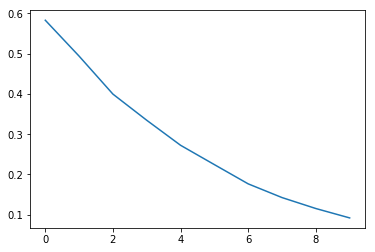

In [13]:
plt.plot(tr_loss_hist, label = 'train')

In [14]:
yhat = char_rnn.predict(sess = sess, X_length = X_length, X_indices = X_indices)

In [15]:
print('training acc: {:.2%}'.format(np.mean(yhat == np.argmax(y, axis = -1))))

training acc: 100.00%
